# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [30]:
import urllib
import matplotlib.pylab as pl
import os
import pandas as pd
import zipfile 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import choroplethNYC as cp
from IPython.display import display

%matplotlib inline
pd.set_option('display.max_columns', 500)
yrs = [str(i) for i in range(94, 100)]+['%02d'%i for i in range(0, 14)]

In [2]:
if os.getenv('PUIDATA') == None:
    os.environ['PUIDATA'] = os.getenv('HOME')+'/PUIdata'

In [3]:
### Programmatically download all zipfiles.
for i in yrs:
    url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp%stotals.zip'%i
    dst = os.getenv('PUIDATA')+'/zbp%stotals.zip'%i    
    urllib.request.urlretrieve(url, dst)
    print(url)

https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp94totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp95totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp96totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp97totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp98totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp99totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp00totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp01totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp02totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp03totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp04totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp05totals.zip
https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp06totals.zip

In [4]:
dt={}
for y in yrs:
    fname = 'zbp%stotals.zip'%y
    print (fname)
    zf = zipfile.ZipFile(os.getenv('PUIDATA')+'/'+fname)
    tmp = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    tmp.columns = [i.lower() for i in tmp.columns]
    dt[y] = tmp[['zip', 'est']]
    dt[y].columns = ['zip', y]

zbp94totals.zip
zbp95totals.zip
zbp96totals.zip
zbp97totals.zip
zbp98totals.zip
zbp99totals.zip
zbp00totals.zip
zbp01totals.zip
zbp02totals.zip
zbp03totals.zip
zbp04totals.zip
zbp05totals.zip
zbp06totals.zip
zbp07totals.zip
zbp08totals.zip
zbp09totals.zip
zbp10totals.zip
zbp11totals.zip
zbp12totals.zip
zbp13totals.zip


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [5]:
! wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip -O files.zip
! unzip -o files.zip -d $PUIDATA
! rm files.zip

--2018-12-13 14:11:14--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2018-12-13 14:11:14--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Reusing existing connection to data.cityofnewyork.us:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘files.zip’

files.zip               [    <=>             ]   1.44M  1.93MB/s    in 0.7s    

2018-12-13 14:11:15 (1.93 MB/s) - ‘files.zip’ saved [1514401]

Archive:  files.zip
  inflating: /nfs

In [6]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [8]:
df = pd.DataFrame(nyczips)
df.columns = ['zip']
df.shape

for y in yrs:
    tmp = dt[y]
    df = df.merge(tmp, how='left', on='zip')
df = df.set_index('zip')
df.tail()

,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13
zip,,,,,,,,,,,,,,,,,,,,
10310,487.0,473.0,447.0,434.0,420.0,429.0,424.0,437.0,453.0,436.0,446.0,456.0,460.0,472.0,466.0,464.0,485.0,470.0,495.0,504.0
11693,95.0,90.0,88.0,83.0,79.0,79.0,79.0,89.0,94.0,98.0,96.0,97.0,104.0,110.0,125.0,131.0,132.0,131.0,129.0,127.0
11249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,114.0,361.0,480.0
10162,17.0,18.0,19.0,17.0,22.0,19.0,21.0,20.0,25.0,28.0,22.0,23.0,17.0,17.0,18.0,19.0,21.0,15.0,21.0,18.0
10119,207.0,212.0,217.0,210.0,235.0,246.0,262.0,280.0,254.0,259.0,267.0,272.0,296.0,301.0,305.0,311.0,314.0,303.0,295.0,293.0


In [9]:
# 20 years of data and 263 zipcodes
cbs = df
cbs.shape # (263,20)

(263, 20)

In [10]:
#cleaning all missing values
cleancsb = cbs.dropna()
cleancsb.shape

(243, 20)

In [11]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T

In [12]:
display(vals.mean(axis=1)[:5])
display(vals.mean(axis=1).shape)
display(vals.std(axis=1)[:5])
display(vals.std(axis=1).shape)

zip
11436   -3.219647e-16
11213   -4.662937e-16
11212    5.884182e-16
11225    8.881784e-17
11218    0.000000e+00
dtype: float64

(243,)

zip
11436    1.0
11213    1.0
11212    1.0
11225    1.0
11218    1.0
dtype: float64

(243,)

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [13]:
#cluster with kmeans
nc = 7
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [14]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [15]:
len(km.cluster_centers_[0])

20

In [16]:
set(km.labels_)

{0, 1, 2, 3, 4, 5, 6}

In [17]:
vals['cluster'] = km.labels_

### The map of the clusters may look something like this

In [18]:
df_clust = vals['cluster'].reset_index()
df_clust['zip'] = df_clust['zip'].astype(str)
df_clust['cluster'] = df_clust['cluster'].astype(int)
df_clust.head()

,zip,cluster
0,11436,3
1,11213,3
2,11212,0
3,11225,0
4,11218,3


In [19]:
df_clust = nyczipsshp.merge(df_clust, how='left', left_on='ZIPCODE', right_on='zip')

/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


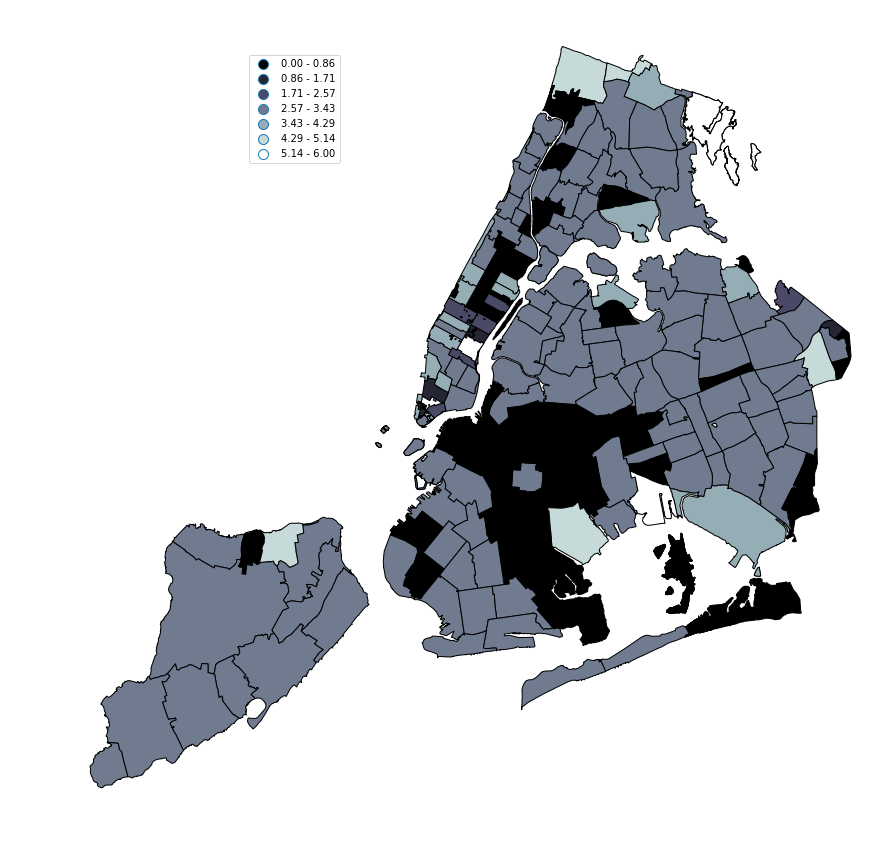

In [20]:
ax = plt.figure(figsize=(15, 15)).add_subplot(111, frameon=False)
ax.axis('off')

df_clust.plot(column='cluster', scheme='Equal_Interval',k=nc, cmap="bone", ax=ax, edgecolor='black',legend=True)

ax.get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0)) 
### inspired from https://github.com/fedhere/choroplethNYC/blob/master/choroplethNYC.py

### Figure 1: 
cloropleth of  cluster centers for 7 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

In [21]:
df_clust.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,cluster
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,3.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,3.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,0.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,0.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,3.0


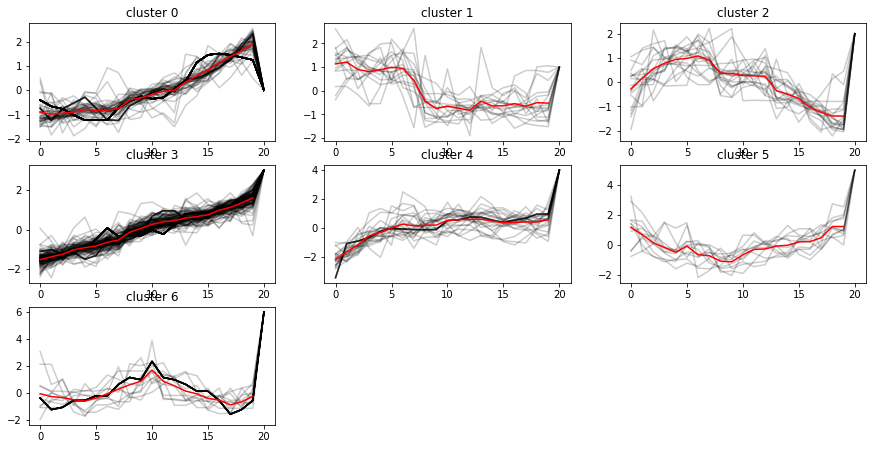

In [22]:
fig = plt.figure(figsize=(15,10))
for i in range(nc):
    zips = df_clust[df_clust.cluster==i].ZIPCODE
    ax = fig.add_subplot(4,3,i+1)
    ax.set_title('cluster %s'%i)
    for j in zips:
        ax.plot(range(21), vals[vals.index==int(j)].values.T, 'k-', alpha=0.2)
    ax.plot(range(20), km.cluster_centers_[i], 'r-', label='center of cluster %s'%i)

### Figure 4: These are the 7 plots of the 7 clusters produced from the KMeans Clustering algorithm as well as its centroid

/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


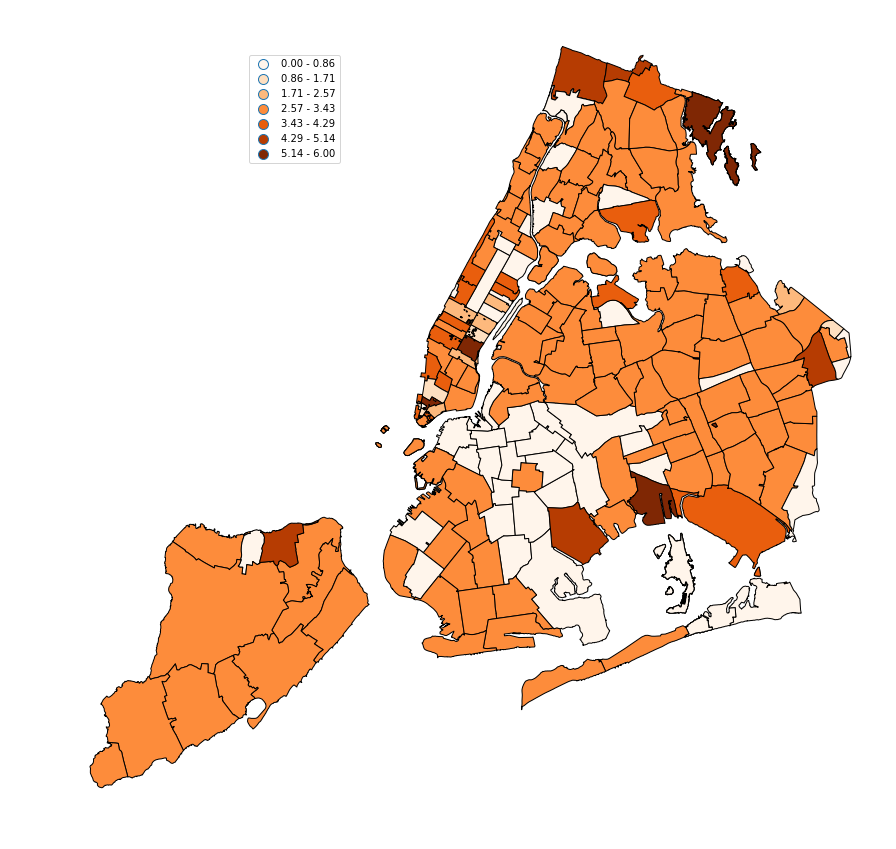

In [23]:
ax = plt.figure(figsize=(15, 15)).add_subplot(111, frameon=False)
ax.axis('off')

df_clust.plot(column='cluster', scheme='Equal_Interval',k=nc, cmap="Oranges", ax=ax, edgecolor='black',legend=True)

ax.get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0)) 
### inspired from https://github.com/fedhere/choroplethNYC/blob/master/choroplethNYC.py

### Figure 5: Choropleth map of the previously mentioned 7 clusters of KMeans Clustering

# If you want to use agglomerative clustering

In [24]:
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
vals2 = vals.drop('cluster', axis=1)
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals2)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))

In [39]:
df_agc = pd.DataFrame({'zip':vals2.index, 'cluster':labelsag})
df_agc.zip = df_agc.zip.astype(str)
print(df_agc.shape)
print(df_agc.dtypes)
df_agc.head()

(243, 2)
zip        object
cluster     int64
dtype: object


,zip,cluster
0,11436,2
1,11213,2
2,11212,2
3,11225,2
4,11218,2


In [40]:
df_agc = nyczipsshp.merge(df_agc, how='left', left_on='ZIPCODE', right_on='zip')

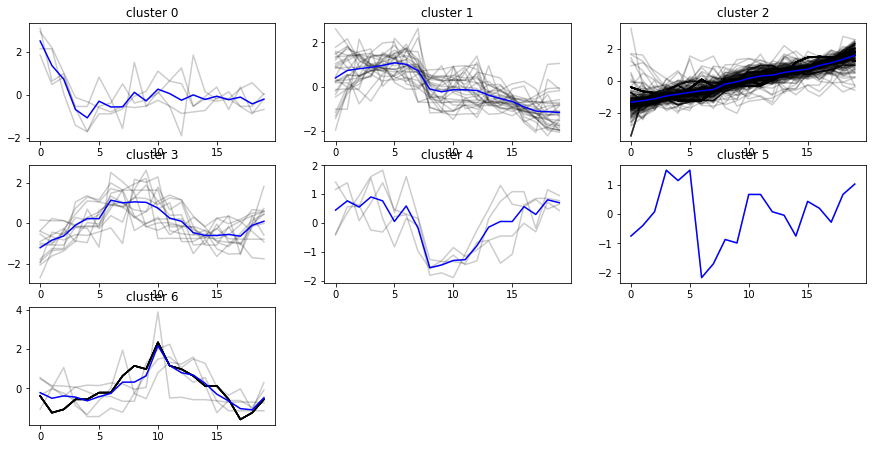

In [101]:
fig = plt.figure(figsize=(15,10))
for i in range(nc):
    zips = df_agc[df_agc.cluster==i].ZIPCODE.astype(int).values
    ax = fig.add_subplot(4,3,i+1)
    ax.set_title('cluster %s'%i)
    for j in zips:
        tmp = vals2[vals2.index==j]
        ax.plot(range(20), tmp.T, 'k-', alpha=0.2)
    tmp = vals2[labelsag==i]
    
#     print(list(zips))
    ax.plot(range(20), np.mean(tmp, axis=0), 'b-', label='center of cluster %s'%i)

### Figure 6: These are 7 plots from the Agglomerative Clustering method as well as its centroid

/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


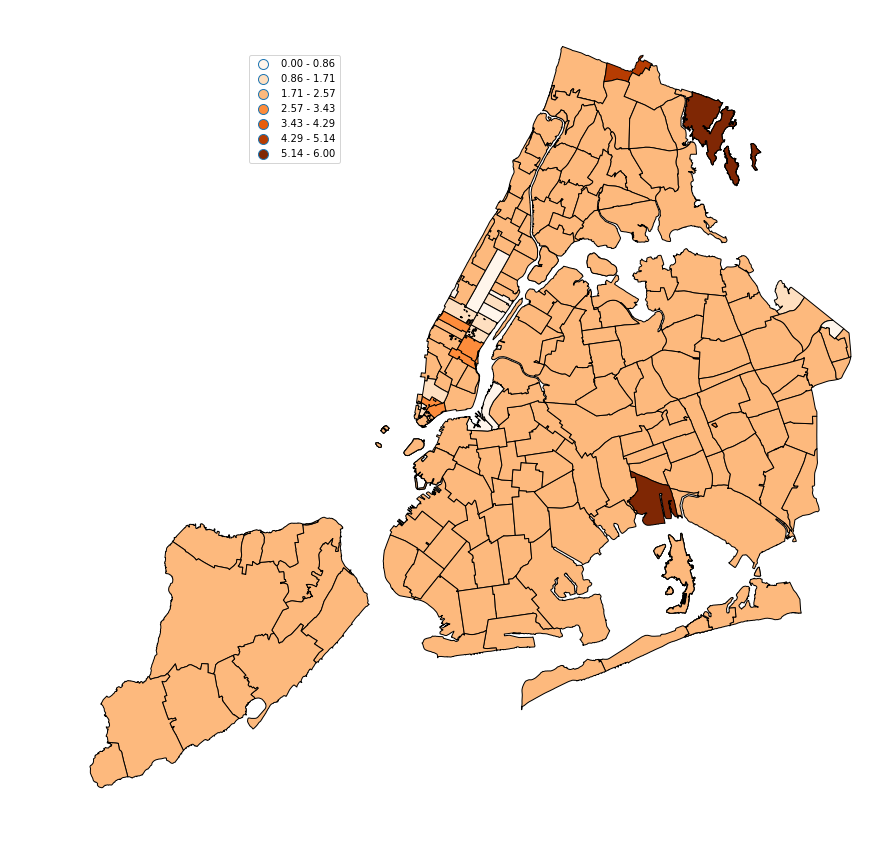

In [102]:
ax = plt.figure(figsize=(15, 15)).add_subplot(111, frameon=False)
ax.axis('off')

df_agc.plot(column='cluster', scheme='Equal_Interval',k=nc, cmap="Oranges", ax=ax, edgecolor='black',legend=True)

ax.get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0)) 
### inspired from https://github.com/fedhere/choroplethNYC/blob/master/choroplethNYC.py

### Figure 7: Choropleth map of the previously mentioned 7 clusters produced by the Agglomerative Clustering method

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

In [106]:
vals2.head()

,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13
zip,,,,,,,,,,,,,,,,,,,,
11436,-1.279776,-1.333890,-1.171550,-1.279776,-1.279776,-0.900984,-0.522192,-0.955097,0.181279,-0.035174,0.505958,0.397732,0.289505,0.505958,0.830637,0.938863,1.263543,1.425882,1.101203,1.317656
11213,-1.452072,-1.312784,-1.183446,-0.954616,-0.755634,-0.785482,-0.745685,-0.586500,-0.059197,0.169632,0.179581,0.040294,0.129836,0.040294,0.398462,0.686986,1.224237,1.214288,1.731641,2.020165
11212,-1.063574,-1.206598,-1.102581,-0.777527,-0.881544,-0.595498,-0.868542,-0.777527,-0.127421,-0.075412,-0.010402,0.002600,-0.218436,0.002600,0.197632,0.782728,1.458839,1.640869,1.744886,1.874907
11225,-1.245223,-1.174371,-1.162563,-0.902772,-0.831920,-0.914581,-0.820112,-0.761068,-0.087975,0.018303,0.065538,0.053729,0.148199,0.325329,0.396181,0.667780,1.104700,1.305447,1.612473,2.202906
11218,-1.504638,-1.353797,-1.182844,-1.052115,-0.835910,-0.680041,-0.619705,-0.524172,-0.282827,-0.187294,0.054051,0.240088,0.235060,0.466350,0.566910,0.868592,0.954069,1.200442,1.612741,2.025039


In [113]:
vals3 = vals2.reset_index()
vals3.head()

,zip,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13
0,11436,-1.279776,-1.333890,-1.171550,-1.279776,-1.279776,-0.900984,-0.522192,-0.955097,0.181279,-0.035174,0.505958,0.397732,0.289505,0.505958,0.830637,0.938863,1.263543,1.425882,1.101203,1.317656
1,11213,-1.452072,-1.312784,-1.183446,-0.954616,-0.755634,-0.785482,-0.745685,-0.586500,-0.059197,0.169632,0.179581,0.040294,0.129836,0.040294,0.398462,0.686986,1.224237,1.214288,1.731641,2.020165
2,11212,-1.063574,-1.206598,-1.102581,-0.777527,-0.881544,-0.595498,-0.868542,-0.777527,-0.127421,-0.075412,-0.010402,0.002600,-0.218436,0.002600,0.197632,0.782728,1.458839,1.640869,1.744886,1.874907
3,11225,-1.245223,-1.174371,-1.162563,-0.902772,-0.831920,-0.914581,-0.820112,-0.761068,-0.087975,0.018303,0.065538,0.053729,0.148199,0.325329,0.396181,0.667780,1.104700,1.305447,1.612473,2.202906
4,11218,-1.504638,-1.353797,-1.182844,-1.052115,-0.835910,-0.680041,-0.619705,-0.524172,-0.282827,-0.187294,0.054051,0.240088,0.235060,0.466350,0.566910,0.868592,0.954069,1.200442,1.612741,2.025039


In [116]:
vals3.dtypes

zip      int64
94     float64
95     float64
96     float64
97     float64
98     float64
99     float64
00     float64
01     float64
02     float64
03     float64
04     float64
05     float64
06     float64
07     float64
08     float64
09     float64
10     float64
11     float64
12     float64
13     float64
dtype: object

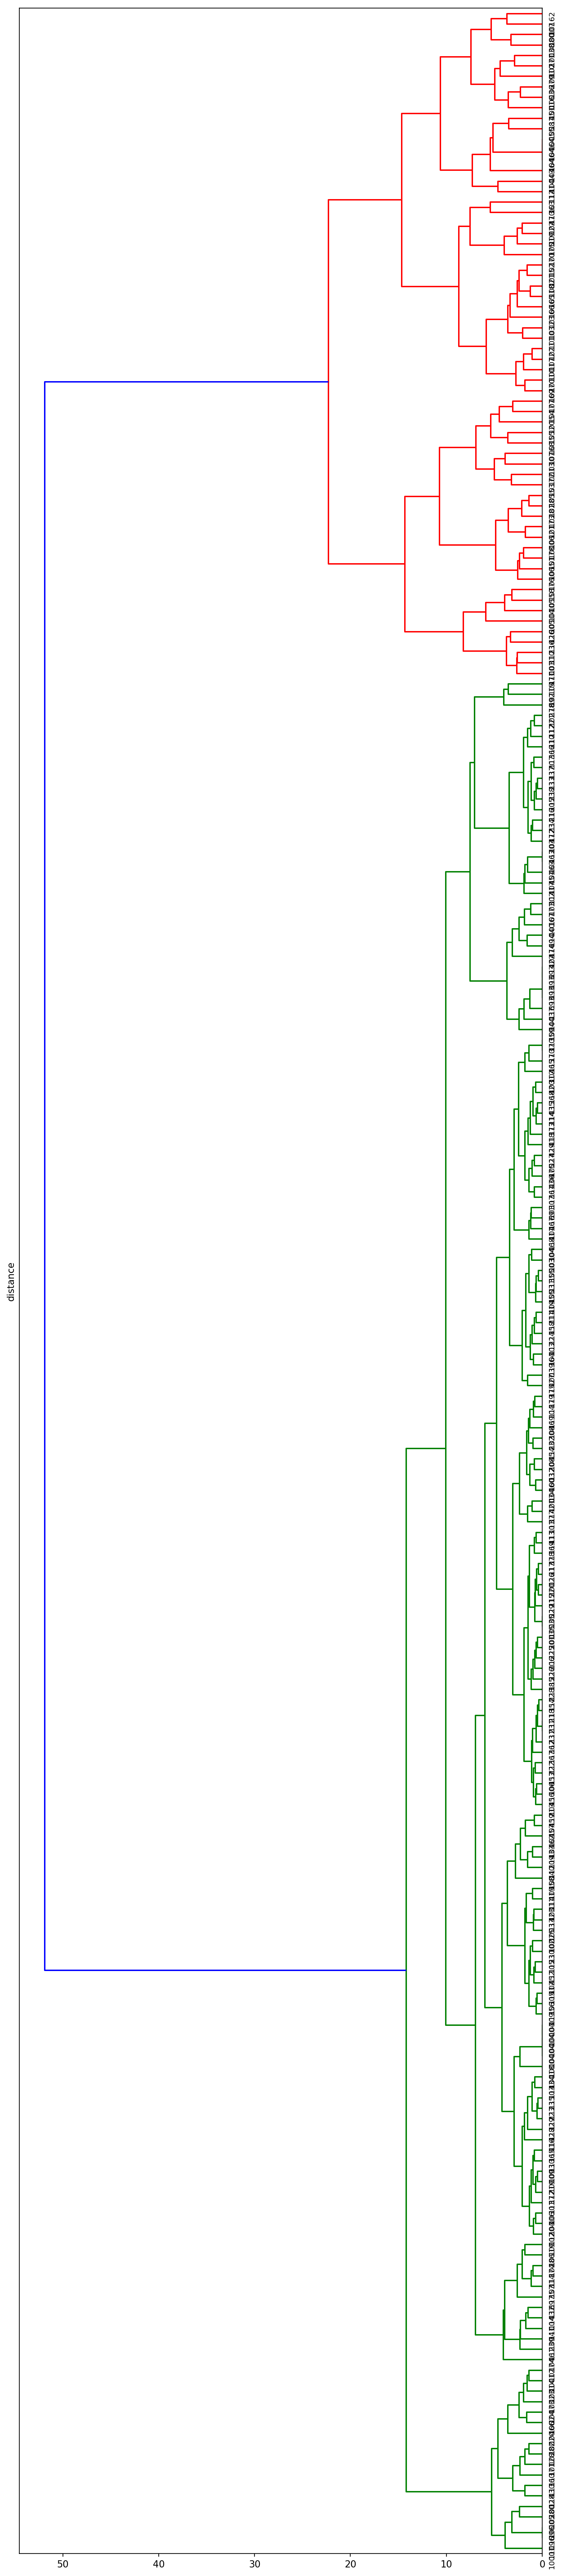

In [122]:
import scipy.cluster as scp
fig = pl.figure(figsize=(10,50), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals2, method='ward'),
                               labels = vals2.index,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.,
                              orientation='left')  # font size for the x axis labels)


### Figure 8: The results of hierarchical clustering